# Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa. 
* W pierwszej wersji należy dokonać dyskretyzacji danych — przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt** 
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [2]:
class NaiveBayes:
    def __init__(self, features, classes, k=4):
        self.features = features
        self.n = features.shape[0]
        self.k = k
        self.n_features = features.shape[1]
        counts = np.bincount(classes)
        self.n_classes = counts.size
        self.priors = counts / self.n

        v_min = np.amin(self.features, axis=1)
        v_max = np.amax(self.features, axis=1)
        self.breakpoints = np.linspace(v_min, v_max, self.k - 1)
        
        self.likelihoods = np.zeros((self.k, self.n_features, self.n_classes))
        for c in range(self.n_classes):
            class_features = features[c == classes]   
            for f in range(self.n_features):
                dicretized = np.digitize(class_features[:, f], self.breakpoints[:, f], right=True)
                counts = np.resize(np.bincount(dicretized), (self.k,))
                self.likelihoods[:, f, c] = counts / np.sum(counts)


    def _discretize_index(self, value, feature):
        return np.searchsorted(self.breakpoints[:, feature], value)

    def predict(self, sample):
        indices = [self._discretize_index(value, feature) for feature, value in enumerate(sample)]
        lpriors = np.log(self.priors)
        p = self.priors * np.prod(self.likelihoods[indices, :, :].diagonal(), axis=1)
        return np.argmax(p)

In [3]:
class GaussianNaiveBayes:
    def __init__(self, features, classes):
        self.features = features
        self.classes = classes
        self.n = features.shape[0]
        self.n_features = features.shape[1]
        counts = np.bincount(classes)
        self.n_classes = counts.size
        self.priors = counts / self.n

        self.std = np.zeros((self.n_features, self.n_classes))
        self.mean = np.zeros((self.n_features, self.n_classes))
        for c in range(self.n_classes):
            class_features = features[c == classes, :]
            self.std[:, c] = np.std(class_features, axis=0)
            self.mean[:, c] = np.mean(class_features, axis=0)


    @staticmethod
    def normal_dist(x, mean, std):
        if std != 0:
            var = std ** 2
            return 1/np.sqrt(2 * np.pi * var) * np.exp(-(x - mean)**2/(2 * var))
        else:
            return 1 if x == mean else 0

    def predict(self, sample):
        p = np.copy(self.priors)
        for c in range(self.n_classes):
            for f in range(self.n_features):
                p[c] *= self.normal_dist(sample[f], self.mean[f, c], self.std[f, c])
        return np.argmax(p)

In [4]:
def accuracy(predictor, xs, ys):
    y_hat = np.array([predictor.predict(x) for x in xs])
    return np.mean(y_hat == ys)

# Dokładność klasyfikatora dla danych dyskretnych dla zadanego przykładu

In [5]:
nb = NaiveBayes(x_train, y_train)
print(f"train {accuracy(nb, x_train, y_train)}")
print(f"test {accuracy(nb, x_test, y_test)}")

train 0.8814814814814815
test 0.9333333333333333


# Dokładność klasyfikatora dla danych ciągłych dla zadanego przykładu

In [6]:
gnb = GaussianNaiveBayes(x_train, y_train)
print(f"train {accuracy(gnb, x_train, y_train)}")
print(f"test {accuracy(gnb, x_test, y_test)}")

train 0.9555555555555556
test 1.0


In [7]:
def avg_accuracy(Predictor, kwarg_iter, average=100):
    avg_accuracies = []
    for kwargs in kwarg_iter:
        accuracies = []
        train_size = kwargs.pop("train_size")
        for _ in range(average):
            x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, train_size=train_size)
            predictor = Predictor(x_train, y_train, **kwargs)
            accuracies.append(accuracy(predictor, x_test, y_test))
        avg_accuracies.append(np.mean(accuracies))
    return avg_accuracies

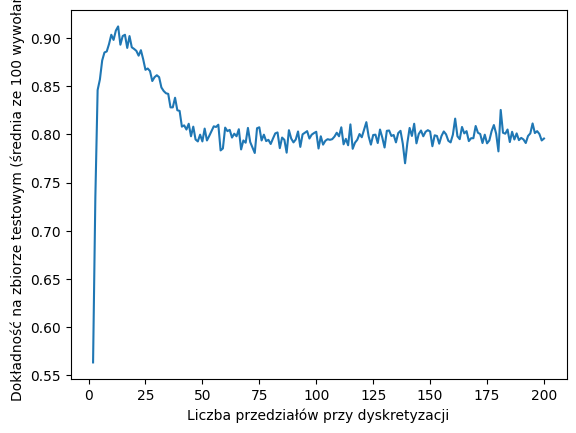

best k = 13


In [8]:
ks = list(range(2, 201))
accuracies = avg_accuracy(NaiveBayes, [{"train_size": 0.8, "k": i} for i in ks])
plt.plot(ks, accuracies)
plt.xlabel("Liczba przedziałów przy dyskretyzacji")
plt.ylabel("Dokładność na zbiorze testowym (średnia ze 100 wywołań)")
plt.show()
best_k = ks[np.argmax(accuracies)]
print(f"best k = {best_k}")

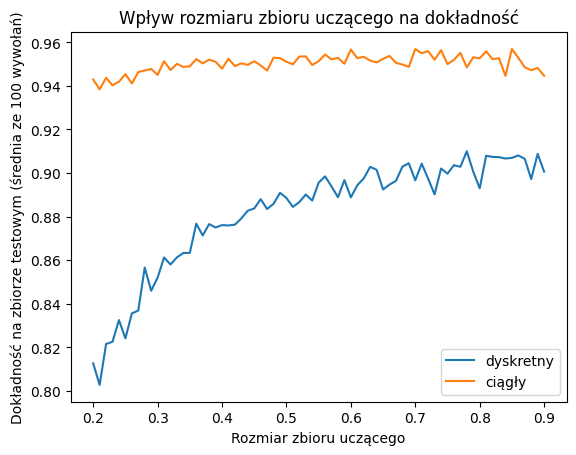

In [9]:
ts = np.arange(0.2, 0.9 + 0.01, 0.01)
nb_acc = avg_accuracy(NaiveBayes, [{"k": best_k, "train_size": t} for t in ts])
gnb_acc = avg_accuracy(GaussianNaiveBayes, [{"train_size": t} for t in ts])
plt.plot(ts, nb_acc, label="dyskretny")
plt.plot(ts, gnb_acc, label="ciągły")
plt.title("Wpływ rozmiaru zbioru uczącego na dokładność")
plt.xlabel("Rozmiar zbioru uczącego")
plt.ylabel("Dokładność na zbiorze testowym (średnia ze 100 wywołań)")
plt.legend()
plt.show()

# Średnie z 1000 uruchomień

In [10]:
print(avg_accuracy(NaiveBayes, [{"k": best_k, "train_size": 0.8}], average=1000)[0])

0.9010666666666668


In [11]:
print(avg_accuracy(GaussianNaiveBayes, [{"train_size": 0.8}], average=1000)[0])

0.9524000000000001


# Wnioski

Algorytm ciągły radzi sobie lepiej od dyskretnego, jednak przy dobraniu odpowiedniej liczby przedziałów uzyskujemy podobne wyniki. Średnia dokładność wnosi około 95%, w porównaniu do poprzednich metod jest raczej mała, jest to najprawdopodobniej wynikiem naiwnego założenia niezależności cech.